# Introduction
In the United States, elections play a crucial role in allowing the public to determine which candidates and their corresponding policies best represent it. Without elections, the government would be unable to enact policies that encompass the concerns of its citizens. However, despite the importance of elections, voter turnout is typically less than 70% across all levels of government. As a result, voter turnout may be a decisive factor in US elections due to the different strategies political parties implement to win them. For instance, while the Democratic Party typically relies on large city populations as its main voter base, the Republican Party relies on winning many non-urban regions with sparse populations. Therefore, we investigate whether party performance is related to voter turnout across different levels of government in the United States. Furthermore, we examine whether political parties perform uniformly across all levels of government within states and whether vote totals within a state affect party wins at certain levels. 

Our analysis found that voter turnout alone does not have a significant relationship with party performance across all levels of government. We observed that while Republican-won counties show a slightly higher mean turnout, the overall participation rate tends to be lower in more heavily populated counties. However, if other factors, such as population and geography, were taken into account along with voter turnout, we could obtain a more accurate insight into party performance. We also found that political parties do not perform uniformly across all levels of government due to state-level party differences, while vote totals within a state do not necessarily affect party wins at certain levels because of the varied relationship between turnout and voter share. The remainder of the report is as follows: We provide a detailed description of our data sets for our analysis. It will cover the contents of the election data. Then, we employ data cleaning and merging procedures to create a uniform data set for analysis. We then produce several descriptive plots to visualize the data and to help understand the relationship between party performance and voter turnout, followed by a discussion of our findings.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import statistics as stats
import numpy as np 
import os

#presidential
pres_county = pd.read_csv("data/president_county_candidate.csv")

#senate
senate_county = pd.read_csv("data/senate_county.csv")
senate_county_candidate = pd.read_csv("data/senate_county_candidate.csv")
senate_state = pd.read_csv("data/senate_state.csv")

#population
state_pop = pd.read_csv("data/state_population.csv") 
#taken from https://data.census.gov/table/DECENNIALCD1182020.P1?q=Population+Total
county_pop = pd.read_excel("data/county_pop.xlsx") 
#taken from https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-total.html

Cleaning State and County Pop

In [2]:
state_pop = state_pop.T
state_pop.columns = state_pop.iloc[0]
state_pop = state_pop.drop(state_pop.index[0]).reset_index()
state_pop.columns = ['state', 'population']
state_pop['population'] = state_pop['population'].str.replace(',', '').astype(int)

In [3]:
county_pop_cols= county_pop.columns
county_pop_cols = county_pop_cols[:2] 
#only keep first two cols
county_pop = county_pop[4:] 
#remove excess rows
county_pop = county_pop[county_pop_cols]
county_pop = county_pop.rename(columns={'table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts)':'county', 'Unnamed: 1':'population'})
county_pop = county_pop.dropna()

In [4]:
county_pop['county'] = county_pop['county'].str.lstrip('.')
county_pop[['county', 'state']] = county_pop['county'].str.split(',', expand=True)
county_pop['state'] = county_pop['state'].str.strip()
county_pop['county'] = county_pop['county'].str.strip()
county_pop['county'] = county_pop['county'].str.lower()
county_pop['state'] = county_pop['state'].str.lower()
county_pop['population'] = county_pop['population'].astype('int')

### President and Voter Share

In [5]:
pres_county['county'] = pres_county['county'].str.lower()
pres_county['state'] = pres_county['state'].str.lower()
pres_county = pres_county[(pres_county['party'] == 'DEM') | (pres_county['party'] == 'REP')]

In [6]:
pres_county = pres_county.merge(county_pop, on=['county', 'state'], how='left')
pres_county = pres_county.dropna()

In [7]:
pres_county = pres_county[pres_county['county'] != 'district of columbia']
pres_county['county_total_votes'] = pres_county.groupby(['state', 'county'])['total_votes'].transform('sum')
pres_county['vote_share'] = pres_county['total_votes'] / pres_county['county_total_votes']

In [8]:
pres_county['turnout'] = pres_county['county_total_votes'] / pres_county['population']
pres_county = pres_county[pres_county['won'] == True]

In [9]:
pres_county.describe()

,total_votes,population,county_total_votes,vote_share,turnout
count,3.043000e+03,3.043000e+03,3.043000e+03,3043.000000,3043.000000
mean,3.094824e+04,1.034345e+05,4.828328e+04,0.703882,0.486714
std,9.726042e+04,3.373890e+05,1.470081e+05,0.108195,0.081826
min,6.000000e+01,6.500000e+01,6.400000e+01,0.500121,0.161668
25%,3.777000e+03,1.081800e+04,5.183000e+03,0.615371,0.433645
50%,8.336000e+03,2.531600e+04,1.194900e+04,0.708987,0.488233
75%,2.096400e+04,6.665150e+04,3.155400e+04,0.791505,0.538552
max,3.028885e+06,1.001740e+07,4.174415e+06,0.968864,0.984615


Plotting Relationships

Figure 1. Vote Share vs. Voter Turnout by Party (Presidential Elections)

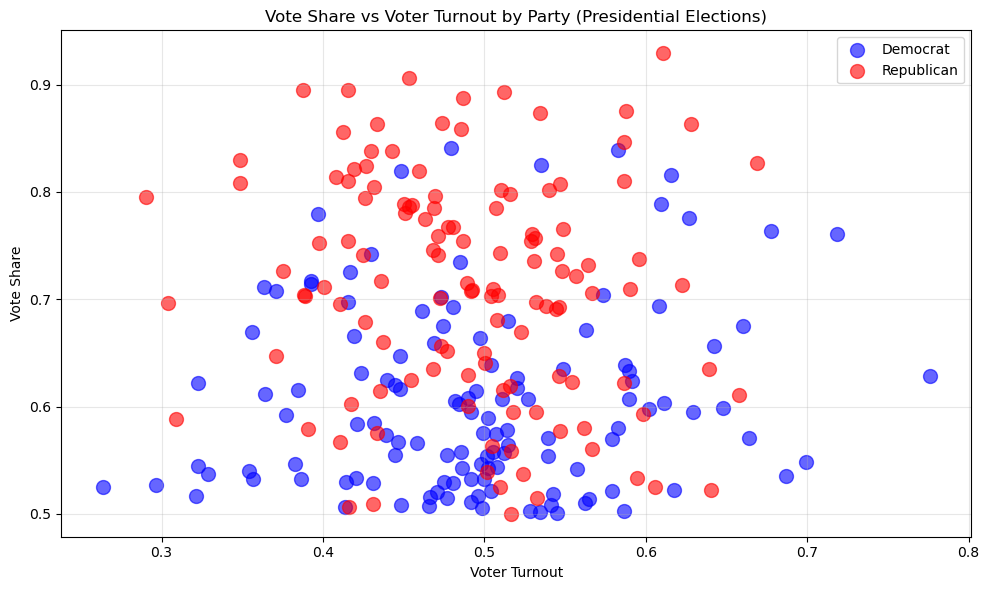

In [10]:
plt.figure(figsize=(10, 6))

dem_data = pres_county[pres_county['party'] == 'DEM'].sample(n=125, random_state=42)
rep_data = pres_county[pres_county['party'] == 'REP'].sample(n=125, random_state=42)

plt.scatter(dem_data['turnout'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turnout'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Vote Share vs Voter Turnout by Party (Presidential Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 1. Vote Share vs. Voter Turnout by Party (Presidential Elections)

This figure visualizes how candidates’ vote shares relate to voter turnout within counties. For both parties, there is no strong linear relationship: counties with higher turnout do not consistently give either party higher vote shares. Instead, both Democratic and Republican vote shares appear widely distributed across turnout levels. This suggests that turnout alone does not systematically favor one party at the county level during presidential elections. Other factors, such as demographic composition or regional patterns, may play a larger role.


Figure 2. Average Voter Turnout by Party (Counties Won)

/var/folders/25/_y0g0nxj2lq3862bk0gkwb580000gn/T/ipykernel_25925/1150895156.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))


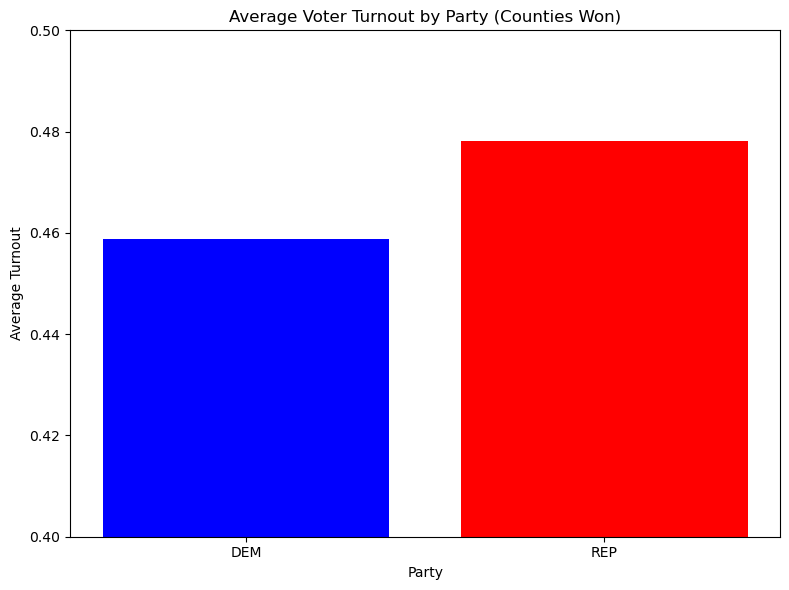

In [11]:
#bar chart of average turnout for rep wins vs dem wins
avg_turnout_by_party = pres_county.groupby('party').apply(lambda x: np.average(x['turnout'], weights=x['population']))

plt.figure(figsize=(8, 6))
plt.bar(avg_turnout_by_party.index, avg_turnout_by_party.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Average Turnout')
plt.title('Average Voter Turnout by Party (Counties Won)')
plt.ylim(0.4, 0.5)
plt.tight_layout()
plt.show()

Figure 2. Average Voter Turnout by Party (Counties Won)

This bar chart compares average turnout in counties won by Democrats versus Republicans. Counties that voted Republican show a slightly higher mean turnout than those won by Democrats. While the difference is not large, it suggests that Republican victories tend to occur in places where a somewhat larger share of eligible voters participate. 


In [12]:
pres_county['margin_of_victory'] = pres_county['vote_share'] - (1-pres_county['vote_share'])
dem_data = pres_county[pres_county['party'] == 'DEM']
rep_data = pres_county[pres_county['party'] == 'REP']

In [13]:
sampled_data = pres_county.sample(n=500, random_state=26)
dem_data = sampled_data[sampled_data['party'] == 'DEM']
rep_data = sampled_data[sampled_data['party'] == 'REP']

Figure 3. Voter Turnout vs. County Population (Presidential Elections)

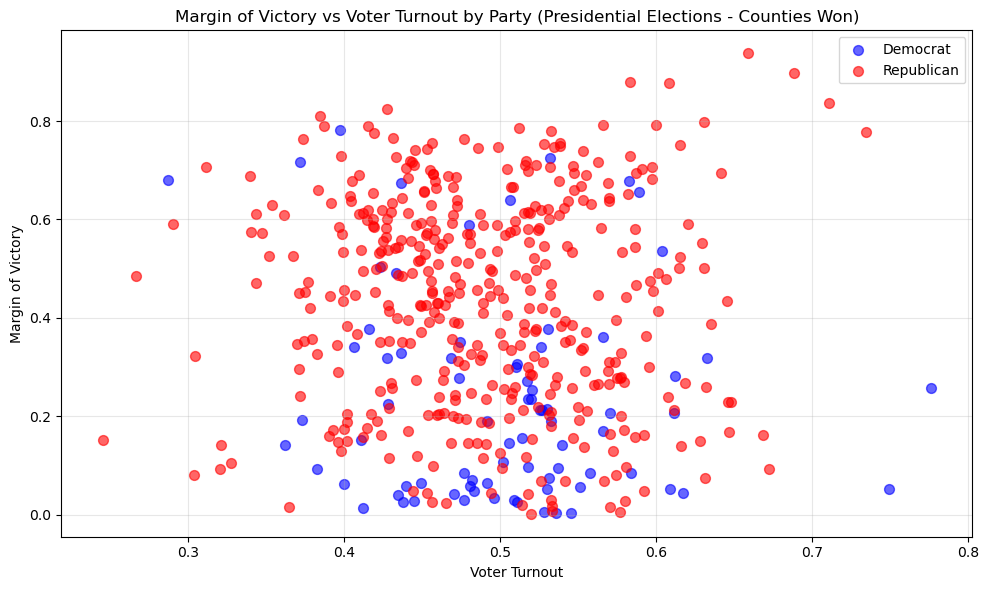

In [14]:
plt.figure(figsize=(10, 6))

plt.scatter(dem_data['turnout'], dem_data['margin_of_victory'], c='blue', label='Democrat', alpha=0.6, s=50)
plt.scatter(rep_data['turnout'], rep_data['margin_of_victory'], c='red', label='Republican', alpha=0.6, s=50)

plt.xlabel('Voter Turnout')
plt.ylabel('Margin of Victory')
plt.title('Margin of Victory vs Voter Turnout by Party (Presidential Elections - Counties Won)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 3. Voter Turnout vs. County Population (Presidential Elections)

This figure shows how voter turnout varies with county population size during presidential elections. The log-scale on the x-axis lets us compare very small rural counties to the largest urban counties. While there is substantial variation in turnout across all population levels, the overall trend line slopes downward, indicating that turnout tends to be slightly lower in more populated counties. Both Democratic and Republican leaning counties appear throughout the turnout range, suggesting that population size influences participation rates more than it predicts which party wins. The broad scatter also shows that many other county-level factors, such as demographics or mobilization efforts, may have shaped turnout beyond population alone.


Fig. 4 Margin of Victory vs. Voter Turnout by Party (Presidential Elections – Counties Won)

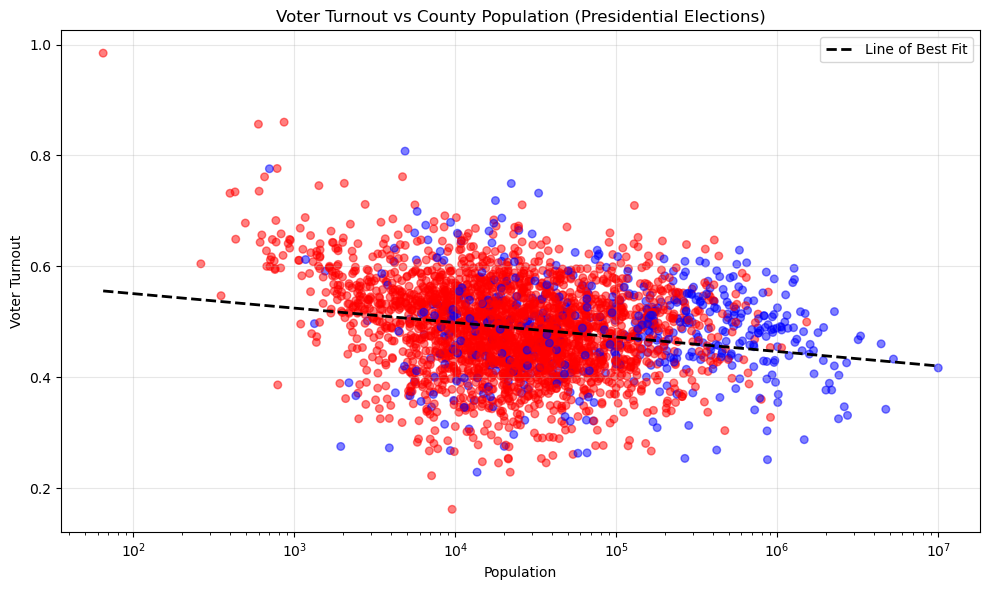

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(pres_county['population'], pres_county['turnout'], c=pres_county['party'].map({'DEM': 'blue', 'REP': 'red'}), alpha=0.5, s=30)
log_pop = np.log10(pres_county['population'])

#line of best fit
coefficients = np.polyfit(log_pop, pres_county['turnout'], 1)
poly = np.poly1d(coefficients)
x_line = np.linspace(log_pop.min(), log_pop.max(), 100)
y_line = poly(x_line)

plt.plot(10**x_line, y_line, color='black', linestyle='--', linewidth=2, label='Line of Best Fit')
plt.xlabel('Population')
plt.ylabel('Voter Turnout')
plt.title('Voter Turnout vs County Population (Presidential Elections)')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Fig. 4 Margin of Victory vs. Voter Turnout by Party (Presidential Elections – Counties Won)

This scatterplot compares voter turnout with the winning candidate’s margin of victory in each county. Each point represents the winning party in that county, colored by party. Overall, there is no strong monotonic relationship between turnout and margin of victory: counties with both high and low turnout can show either close races or landslide wins. The main takeaway is that turnout alone does not determine the competitiveness of a race. Counties with similar turnout levels can behave very differently depending on their political composition.


### Senate Vote Share

In [16]:
senate_county_candidate = senate_county_candidate[(senate_county_candidate['party'] == 'REP') | (senate_county_candidate['party'] == 'DEM')]
vote_state = senate_county_candidate.groupby(['state', 'party'])['total_votes'].sum().reset_index()
vote_state = vote_state.rename(columns={'total_votes': 'candidate_votes'})

vote_state = vote_state.merge(senate_state, how='right', on=['state'])
vote_state = vote_state.merge(state_pop, how='right', on=['state'])

vote_state['vote_share'] = (vote_state['candidate_votes'] / vote_state['total_votes'])
vote_state = vote_state.dropna()


In [17]:
vote_state['turn_out'] = (vote_state['total_votes'] / vote_state['population'])

In [18]:
vote_state.describe()

,candidate_votes,total_votes,population,vote_share,turn_out
count,6.600000e+01,6.600000e+01,6.600000e+01,66.000000,66.000000
mean,5.570670e+05,2.639212e+06,5.589470e+06,0.196179,0.487142
std,6.168936e+05,2.289662e+06,5.460842e+06,0.109272,0.051159
min,2.773000e+03,2.708660e+05,5.768510e+05,0.006599,0.382359
25%,1.374128e+05,8.290938e+05,1.805064e+06,0.106482,0.459347
50%,2.616430e+05,2.134667e+06,4.505836e+06,0.189661,0.473844
75%,7.083740e+05,3.564136e+06,7.151502e+06,0.266818,0.523644
max,2.456123e+06,1.114404e+07,2.914550e+07,0.499781,0.601297


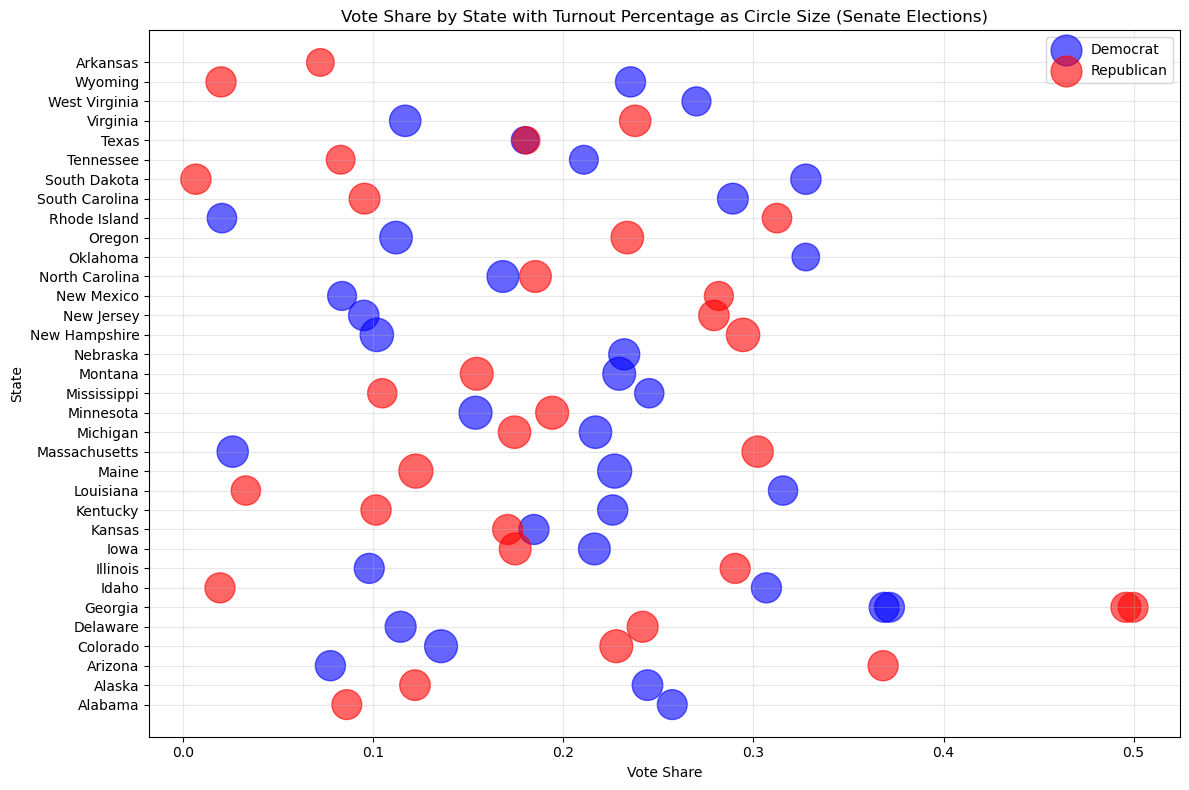

In [19]:
plt.figure(figsize=(12, 8))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

dem_sizes = dem_data['turn_out'] * 1000
rep_sizes = rep_data['turn_out'] * 1000

plt.scatter(dem_data['vote_share'], dem_data['state'], s=dem_sizes, c='blue', alpha=0.6, label='Democrat')
plt.scatter(rep_data['vote_share'], rep_data['state'], s=rep_sizes, c='red', alpha=0.6, label='Republican')

plt.xlabel('Vote Share')
plt.ylabel('State')
plt.title('Vote Share by State with Turnout Percentage as Circle Size (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

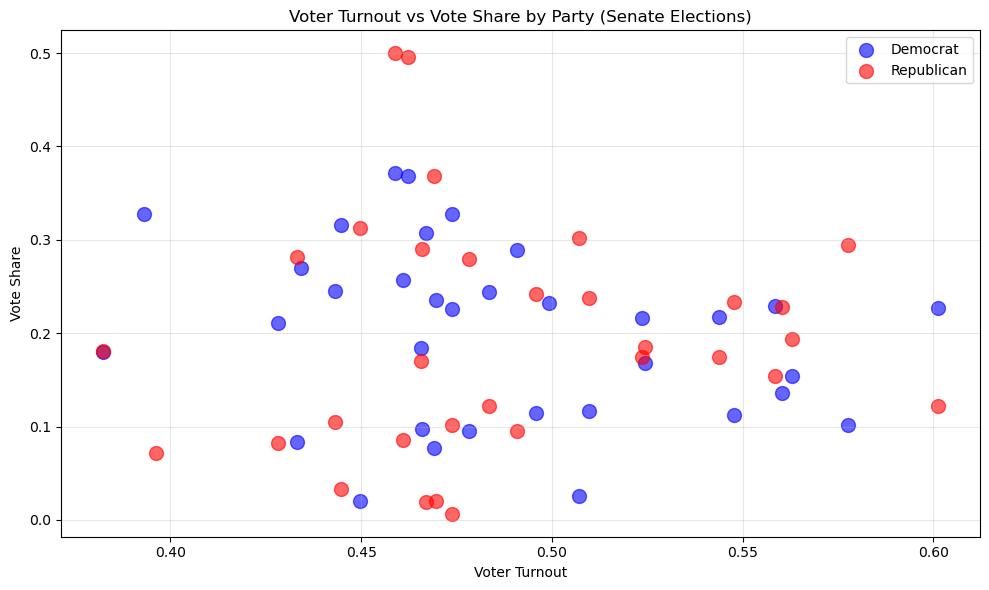

In [20]:
#scatter plot for vote share and turn out, color of the dot depends on party
plt.figure(figsize=(10, 6))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Voter Turnout vs Vote Share by Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
vote_state = vote_state.loc[vote_state.groupby(['state'])['vote_share'].idxmax()]

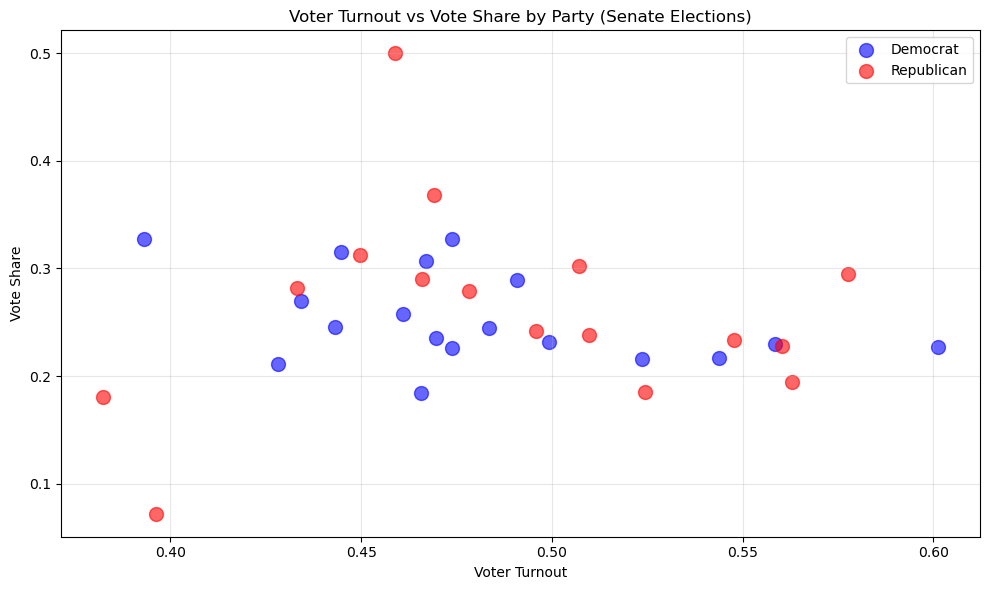

In [22]:
plt.figure(figsize=(10, 6))

dem_data = vote_state[vote_state['party'] == 'DEM']
rep_data = vote_state[vote_state['party'] == 'REP']

plt.scatter(dem_data['turn_out'], dem_data['vote_share'], c='blue', label='Democrat', alpha=0.6, s=100)
plt.scatter(rep_data['turn_out'], rep_data['vote_share'], c='red', label='Republican', alpha=0.6, s=100)

plt.xlabel('Voter Turnout')
plt.ylabel('Vote Share')
plt.title('Voter Turnout vs Vote Share by Party (Senate Elections)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

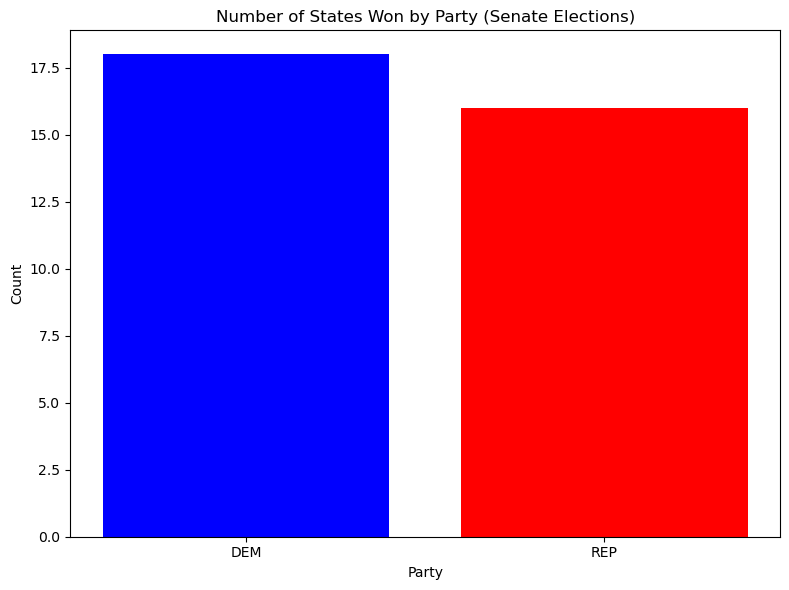

In [23]:
party_counts = vote_state['party'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(party_counts.index, party_counts.values, color=['blue', 'red'])
plt.xlabel('Party')
plt.ylabel('Count')
plt.title('Number of States Won by Party (Senate Elections)')
plt.tight_layout()
plt.show()

# Conclusion and Discussion
The primary result of our investigation was that voter turnout alone does not have a significant relationship with party performance across all levels of government. Instead, party success in elections appears to be linked to contextual factors, such as population and geography, which were taken into account along with voter turnout, as indicated by the non-uniform performance of political parties across all levels of government. Future analyses of this relationship should incorporate more regionally in-depth variables, like demographics, to gain an enhanced understanding of the determinants of voter political party performance.